## Evaluate the Outcomes of Simulatinos
Make sure that the simulations ran as expected

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import json

## Load Simulation Results
Get the results from simulation tasks

In [2]:
def load_tasks(run_path: str) -> pd.DataFrame:
    task_info = []
    with open(f'{run_path}/simulation-results.json') as fp:
        for line in fp:
            try:
                record = json.loads(line)
            except json.JSONDecodeError: 
                continue
            for f in ['task_id', 'failure_info', 'worker_info', 'serialization_method',
                     'additional_timing']:
                record.pop(f)
            record['recipes'] = [f'{x["name"]}/{x["level"]}' for x in record['task_info']['recipes']][0]
            record['recipe'] = record['recipes']
            record['property'], record['level'] = record['recipe'].split("/")
            record['molecule'] = record['task_info']['key']
            task_info.append(record)
    task_info = pd.DataFrame(task_info)
    print(f'Loaded {len(task_info)} task records')
    
    # Group simulation tasks by recipe and molecule
    grouped_tasks = task_info.groupby(['molecule', 'recipe', 'property', 'level']).agg({'time_running': 'sum', 'time_result_received': 'min'}).sort_values('time_result_received')
    grouped_tasks['walltime'] = grouped_tasks['time_result_received'] - grouped_tasks['time_result_received'].min()
    grouped_tasks['compute_time'] = grouped_tasks['time_running'].cumsum()
    grouped_tasks.reset_index(inplace=True)
    print(f'Consolidated to {len(grouped_tasks)} computations')
    
    # Store the results
    db = {}
    with open(f'{run_path}/database.json') as fp:
        for line in fp:
            record = json.loads(line)
            db[record['key']] = record
    grouped_tasks['result'] = grouped_tasks.apply(lambda x: db.get(x['molecule'], {}).get('properties', {}).get(x['property'], {}).get(x['level']), axis=1)
    grouped_tasks['smiles'] = grouped_tasks.apply(lambda x: db.get(x['molecule'], {}).get('identifier', {}).get('smiles'), axis=1)
    return grouped_tasks

In [3]:
multfi_tasks = load_tasks('run')

Loaded 1484 task records
Consolidated to 763 computations


In [4]:
singfi_tasks = load_tasks('run-single')
singfi_tasks.head()

Loaded 747 task records
Consolidated to 200 computations


,molecule,recipe,property,level,time_running,time_result_received,walltime,compute_time,result,smiles
0,QFBFWZJEZIPSJL-UHFFFAOYSA-N,oxidation_potential/mopac_pm7-acn-adiabatic,oxidation_potential,mopac_pm7-acn-adiabatic,60.692114,1.700582e+09,0.000000,60.692114,6.803651,CCOC(C(C)OC)C(Br)(OC)c1ccc(CCOC)cc1
1,SQTARUJWLRWTLF-UHFFFAOYSA-N,oxidation_potential/mopac_pm7-acn-adiabatic,oxidation_potential,mopac_pm7-acn-adiabatic,107.319920,1.700582e+09,17.349539,168.012034,NaN,COCCc1ccc(C(CCOC)(OC(C)C)C(COC)OCOC)cc1
2,QPOBPKSMCMYIIZ-UHFFFAOYSA-N,oxidation_potential/mopac_pm7-acn-adiabatic,oxidation_potential,mopac_pm7-acn-adiabatic,69.718892,1.700582e+09,26.168842,237.730927,NaN,CCOC(Oc1ccccc1)C(COC)(OC)c1ccc(COC)cc1
3,VHOYIGKPMQZVGX-UHFFFAOYSA-N,oxidation_potential/mopac_pm7-acn-adiabatic,oxidation_potential,mopac_pm7-acn-adiabatic,48.576073,1.700582e+09,34.116643,286.306999,5.634255,CCOC(Oc1ccccc1)C(Br)(c1ccc(C(C)C)cc1)N(C)C
4,PQCDVSSBIJWVQW-UHFFFAOYSA-N,oxidation_potential/mopac_pm7-acn-adiabatic,oxidation_potential,mopac_pm7-acn-adiabatic,24.458341,1.700582e+09,65.090125,310.765340,6.369714,CCOC(OC)(c1ccc(CCOC)cc1)C(CC)Oc1ccccc1


## Plot Task Mix by Time
See how many tasks of each time we have run by each timestamp

In [5]:
all_recipes = set(multfi_tasks['recipe'])

Text(0.5, 0, 'Walltime (hr)')

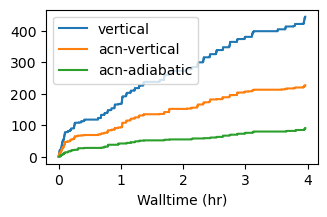

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

for recipe in all_recipes:
    count = (multfi_tasks['recipe'] == recipe).cumsum()
    ax.step(multfi_tasks['walltime'] / 3600, count, label=recipe[30:])
    
    ax.legend()

ax.set_xlabel('Walltime (hr)')

## Plot IP by Walltime
See how well we're doing for each recipe

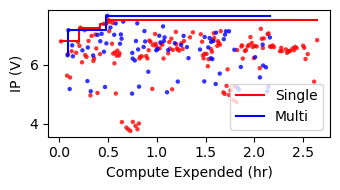

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

for color, label, tasks in zip(['red', 'blue'], ['Single', 'Multi'], [singfi_tasks, multfi_tasks]):
    subset = tasks.query('level=="mopac_pm7-acn-adiabatic"')
    subset = subset[~subset['result'].isnull()]
    ax.scatter(subset['compute_time'] / 3600, subset['result'], s=10, 
               color=color, alpha=0.8, edgecolor='none')
    cummax = subset['result'].cummax()
    ax.step(subset['compute_time'] / 3600, cummax, '-', color=color, label=label)

ax.set_xlabel('Compute Expended (hr)')
ax.set_ylabel('IP (V)')

ax.legend()

fig.tight_layout()

Plot the distribution of IPs after 2 hours of compute

Single - Mean: 6.26 V - Count: 118
Multi - Mean: 6.49 V - Count: 71


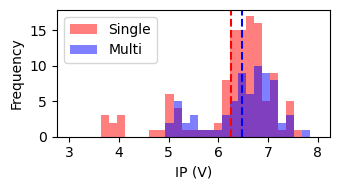

In [9]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

bins = np.linspace(3, 8, 32)
means = []
for color, label, tasks in zip(['red', 'blue'], ['Single', 'Multi'], [singfi_tasks, multfi_tasks]):
    subset = tasks.query('level=="mopac_pm7-acn-adiabatic" and compute_time <= 7200')
    subset = subset[~subset['result'].isnull()]
    ax.hist(subset['result'], bins=bins, color=color, label=label, alpha=0.5)
    print(f'{label} - Mean: {subset["result"].mean():.2f} V - Count: {len(subset)}')
    
    means.append((color, subset['result'].mean()))

ax.set_ylim(ax.get_ylim())
for color, mean in means:
    ax.plot([mean] * 2, ax.get_ylim(), '--', color=color)

ax.set_xlabel('IP (V)')
ax.set_ylabel('Frequency')

ax.legend()

fig.tight_layout()

The average IP of the molecules run at the highest level is higher for the multi-fidelity case, though there are are fewer overall